In [ ]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import pathlib
import pandas as pd

from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
from tqdm import tqdm
tqdm.pandas()

In [ ]:
RS = 7345

# Загрузка данных

In [ ]:
train = pd.read_csv("train.csv", index_col="pair_id")
test = pd.read_csv("test.csv", index_col="pair_id")

In [ ]:
train.head()

,name_1,name_2,is_duplicate
pair_id,,,
1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0
2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0
3,"Rishichem Distributors Pvt., Ltd.",Dsa,0
4,Powermax Rubber Factory,Co. One,0
5,Tress A/S,Longyou Industries Park Zhejiang,0


In [ ]:
test.head()

,name_1,name_2
pair_id,,
1,Sun Blinds Decoration Inc.,Indl De Cuautitlan Sa Cv
2,Eih Ltd.,"Dongguan Wei Shi Plastic Product Co., Ltd."
3,Jsh Ltd. (Hk),Arab Shipbuilding And Repair Yard C
4,Better Industrial Ltd.,Farmacap Industria E Comercio Ltda
5,Equipos Inoxidables Del Norte Sa De Cv,Bel Inc.


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497819 entries, 1 to 497819
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   name_1        497819 non-null  object
 1   name_2        497819 non-null  object
 2   is_duplicate  497819 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 15.2+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213249 entries, 1 to 213249
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   name_1  213249 non-null  object
 1   name_2  213249 non-null  object
dtypes: object(2)
memory usage: 4.9+ MB


# Статистика таргета

In [ ]:
train.is_duplicate.value_counts()

0    494161
1      3658
Name: is_duplicate, dtype: int64

In [ ]:
train[train.is_duplicate==1].sample(15)

,name_1,name_2,is_duplicate
pair_id,,,
395382,Ikea Distribution Services Gmb H,Ikea Distribution Service(Shanghai),1
209566,Bridgestone Tire,Bridgestone (China) Research And Development C...,1
263594,Dow Chemical Thailand Ltd.,Dow Chemical Pacific,1
458214,Freudenberg Nok De Mexico Sa De Cv,Freudenberg Nok Componentes Brasil Ltda,1
388667,Arlanxeo Brasil Sa,Arlanxeo Singapore Pte.,1
158075,Basf Pakistan (Private) Ltd.,"Basf Co., Ltd.",1
163396,Soprema Canada,SOPREMA OBERROSSBACH,1
390723,"Sumitomo Rubber (Changshu) Co., Ltd.",Sumitomo Rubber Do Brasil Ltda,1
56580,Yokohama Tire Canada,Yokohama Re Mfg.,1


In [ ]:
train[train.is_duplicate==0].sample(15)

,name_1,name_2,is_duplicate
pair_id,,,
130514,R.H. Claydon Ltd.(Saxham),R.I.Intl,0
213799,Solid Cement,Lg Chem Ltd.,0
237941,Zara Brasil Ltd. Av Ribeirao Dos Cri,V.D.,0
62414,"Carlton Overseas Pvt., Ltd.",Infusion Overseas Private Ltd.,0
275797,Sportworx 2012 Ltd.,Elisei Nastri Trasportatori,0
138235,"Genius Industrial Supply Co., Ltd.",D S International,0
154412,Great Worldwide Logistics,Ez Logistics Llc,0
284958,Hps North America Inc.,Icl America Ltd.,0
150053,Gates India P. Ltd.,Indo Rama Synthetics (India) Ltd.,0


# Очистка данных

In [ ]:
!pip install pycountry

     |████████████████████████████████| 10.1MB 3.7MB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746864 sha256=34a264e1ff4c056af58f26f5daa8505fead06ab4a40f4381eca71d37a5196dfd
  Stored in directory: /root/.cache/pip/wheels/33/4e/a6/be297e6b83567e537bed9df4a93f8590ec01c1acfbcd405348
Successfully built pycountry


In [ ]:
import pycountry
import re

In [ ]:
countries = [country.name.lower() for country in pycountry.countries]

In [ ]:
train["name_1"] = train["name_1"].str.lower()
train["name_2"] = train["name_2"].str.lower()

test["name_1"] = test["name_1"].str.lower()
test["name_2"] = test["name_2"].str.lower()

In [ ]:
train[train.name_1.str.contains("gmbh")]

,name_1,name_2,is_duplicate
pair_id,,,
40,isoliererzeugnisse grobrohrsdorf gmbh,total rumunia,0
410,dortmunder gussasphalt gmbh & co. kg,bitoumina s.a.,0
440,celanese chemicals europe gmbh,inreco - emulsja sp. z o.o.,0
583,tremco illbruck group gmbh,wakol gmbh,0
681,rasco bitumentechnik gmbh,technpvinyl polymers india ltd.,0
...,...,...,...
497197,binne & sohn gmbh & co kg,buscher hoffmann,0
497306,mct gmbh & co. kg,valli zabban,0
497366,mct misch & compoundier technik gmbh,nknh,0


In [ ]:
legal_entities = ["ltd.", "co.", "inc.", "b.v.", "s.c.r.l.", "gmbh", "pvt."]

for entity in tqdm(legal_entities):
    train.replace(re.compile(f"\s+{entity}\s*"), "", inplace=True)
    test.replace(re.compile(f"\s+{entity}\s*"), "", inplace=True)

100%|██████████| 7/7 [00:14<00:00,  2.14s/it]


In [ ]:
train.head()

,name_1,name_2,is_duplicate
pair_id,,,
1,iko industries,"enormous industrial trade,",0
2,apcotex industries,technocraft industries (india),0
3,"rishichem distributors,",dsa,0
4,powermax rubber factory,co. one,0
5,tress a/s,longyou industries park zhejiang,0


In [ ]:
test.head()

,name_1,name_2
pair_id,,
1,sun blinds decoration,indl de cuautitlan sa cv
2,eih,"dongguan wei shi plastic product,"
3,jsh(hk),arab shipbuilding and repair yard c
4,better industrial,farmacap industria eercio
5,equipos inoxidables del norte sa de cv,bel


In [ ]:
train.replace(re.compile(r"\s+\(.*\)"), "", inplace=True)
test.replace(re.compile(r"\s+\(.*\)"), "", inplace=True)

In [ ]:
for country in tqdm(countries):
    train.replace(re.compile(country), "", inplace=True)
    test.replace(re.compile(country), "", inplace=True)

100%|██████████| 249/249 [06:31<00:00,  1.57s/it]


In [ ]:
train.replace(re.compile(r"[^\w\s]"), "", inplace=True)
test.replace(re.compile(r"[^\w\s]"), "", inplace=True)

In [ ]:
train.sample(5)

,name_1,name_2,is_duplicate
pair_id,,,
454977,alpha enterprises,sankalp enterprises,0
356406,optimas oe solutions private,ohsung electronics private limtied,0
341593,embatiba industria eercio,socer brasil industries e,0
161073,logistics usa,b m logistica international,0
411256,ford vietnam,risun vietnam one member,0


In [ ]:
test.sample(5)

,name_1,name_2
pair_id,,
15927,litrans logistica international de transportesepp,nrs logisticsas agent for
38955,apl logistics for,ares international logistics
63827,ubi banca,i b international
86003,beyond materials,chem trendercial sa de cv
168249,volkswagen private,sas engineering


# Замена на транскрипцию всех слов

In [ ]:
!pip install transliterate

     |████████████████████████████████| 51kB 3.0MB/s 


In [ ]:
from transliterate import translit, get_available_language_codes, slugify

def transliterate_text(text):
  t = slugify(text)
  return t if t is not None else text

In [ ]:
train['trans_name_1'] = train['name_1'].apply(transliterate_text)
train['trans_name_2'] = train['name_2'].apply(transliterate_text)
test['trans_name_1']  = test['name_1'].apply(transliterate_text)
test['trans_name_2']  = test['name_2'].apply(transliterate_text)

In [ ]:
train[(train.name_1 != train.trans_name_1) & (train.is_duplicate == 1)].head()

,name_1,name_2,is_duplicate,trans_name_1,trans_name_2
pair_id,,,,,
3372,ооо химинвест групп,химинвест групп ооо,1,ooo-himinvest-grupp,himinvest-grupp-ooo
5118,оооимпорт мода,оооимпорт мода,1,oooimport-moda,oooimport-moda
11654,onur taahhüt,onur taahhut tasimacilik insaat ticaret ve san...,1,onur-taahhuet,onur taahhut tasimacilik insaat ticaret ve san...
12161,ооогуччи рус,ооогуччи рус,1,oooguchchi-rus,oooguchchi-rus
24519,филиал компании эксон нефтегаз лимитед,филиал компанииэксон нефтегаз лимитед,1,filial-kompanii-ekson-neftegaz-limited,filial-kompaniiekson-neftegaz-limited


# Lemmatizer

In [ ]:
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
lemmatizer = WordNetLemmatizer() #  lemmatizer.lemmatize(word)
# stemmer = PorterStemmer() # stemmer.stem(word)

train['lemm_name_1'] = train['trans_name_1'].apply(lambda sentence: ' '.join([lemmatizer.lemmatize(w) for w in sentence.rstrip().split()])) 
train['lemm_name_2'] = train['trans_name_2'].apply(lambda sentence: ' '.join([lemmatizer.lemmatize(w) for w in sentence.rstrip().split()])) 

test['lemm_name_1']  = test['trans_name_1'].apply(lambda sentence: ' '.join([lemmatizer.lemmatize(w) for w in sentence.rstrip().split()])) 
test['lemm_name_2']  = test['trans_name_2'].apply(lambda sentence: ' '.join([lemmatizer.lemmatize(w) for w in sentence.rstrip().split()])) 

In [ ]:
from nltk.corpus import stopwords

en = stopwords.words("english")
# rus = stopwords.words("russian")
# stop_words = en + rus
stop_words = en 

train['stopw_name_1'] = train['lemm_name_1'].apply(lambda sentence: ' '.join([w for w in sentence.rstrip().split() if not w in stop_words])) 
train['stopw_name_2'] = train['lemm_name_2'].apply(lambda sentence: ' '.join([w for w in sentence.rstrip().split() if not w in stop_words])) 

test['stopw_name_1']  = test['lemm_name_1'].apply(lambda sentence: ' '.join([w for w in sentence.rstrip().split() if not w in stop_words])) 
test['stopw_name_2']  = test['lemm_name_2'].apply(lambda sentence: ' '.join([w for w in sentence.rstrip().split() if not w in stop_words])) 

In [ ]:
train.head()

,name_1,name_2,is_duplicate,trans_name_1,trans_name_2,lemm_name_1,lemm_name_2,stopw_name_1,stopw_name_2
pair_id,,,,,,,,,
1,iko industries,enormous industrial trade,0,iko industries,enormous industrial trade,iko industry,enormous industrial trade,iko industry,enormous industrial trade
2,apcotex industries,technocraft industries,0,apcotex industries,technocraft industries,apcotex industry,technocraft industry,apcotex industry,technocraft industry
3,rishichem distributors,dsa,0,rishichem distributors,dsa,rishichem distributor,dsa,rishichem distributor,dsa
4,powermax rubber factory,co one,0,powermax rubber factory,co one,powermax rubber factory,co one,powermax rubber factory,co one
5,tress as,longyou industries park zhejiang,0,tress as,longyou industries park zhejiang,tress a,longyou industry park zhejiang,tress,longyou industry park zhejiang


# CountVectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

documents = pd.concat([train['stopw_name_1'], train['stopw_name_2']]).values.astype('U')
count_vectorizer = CountVectorizer(max_features=500) # memory limit: ngram_range=(2, 5),
values = count_vectorizer.fit_transform(documents)
frequency = values.toarray().sum(axis=0)

feature_names = count_vectorizer.get_feature_names()
count_train = pd.DataFrame({'feature_names': feature_names, 'frequency': frequency})

In [ ]:
count_train.head(10)

,feature_names,frequency
433,international,96481
207,de,88605
421,industry,73258
736,sa,72389
900,trading,50473
508,logistics,49826
198,cv,46391
731,rubber,38804
672,private,33319
502,llc,31425


# TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

documents = pd.concat([train['stopw_name_1'], train['stopw_name_2']]).values.astype('U')
tfidf_vectorizer = TfidfVectorizer(max_features=500) # memory limit: ngram_range=(2, 5),
values = tfidf_vectorizer.fit_transform(documents)
frequency = values.toarray().sum(axis=0)

# Show the Model as a pandas DataFrame
feature_names = tfidf_vectorizer.get_feature_names()
tf_idf_train = pd.DataFrame({'feature_names': feature_names, 'frequency': frequency})

In [ ]:
tf_idf_train = tf_idf_train.sort_values(by=['frequency'], ascending=False)
tf_idf_train.head(10)

,feature_names,frequency
433,international,54241.109687
421,industry,45633.147254
736,sa,37276.041315
207,de,33893.185439
508,logistics,30495.161240
900,trading,30255.941137
731,rubber,22605.982851
672,private,22603.325698
198,cv,20228.930637
502,llc,17986.533492


In [ ]:
tf_idf_train.to_csv('train_tf_idf.csv', index=False)

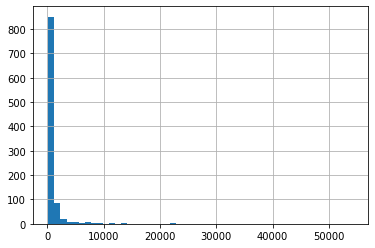

In [ ]:
tf_idf_train['frequency'].hist(bins=50)

# Delete popular words

In [ ]:
# remove 20% most popular words

perc = 0.2
size = int(len(count_train) * perc)

count_stop = count_train['feature_names'].iloc[:size].values
tf_idf_stop = tf_idf_train['feature_names'].iloc[:size].values

In [ ]:
train.dtypes

name_1          object
name_2          object
is_duplicate     int64
lemm_name_1     object
lemm_name_2     object
stopw_name_1    object
stopw_name_2    object
dtype: object

In [ ]:
popular_words = set(count_stop) | set(tf_idf_stop)

In [ ]:
train.fillna('', inplace=True)
test.fillna('', inplace=True)

In [ ]:
train['clean_name_1'] = train['stopw_name_1'].apply(lambda s: ' '.join([w for w in s.rstrip().split() if not w in popular_words])) 
train['clean_name_2'] = train['stopw_name_2'].apply(lambda s: ' '.join([w for w in s.rstrip().split() if not w in popular_words])) 

test['clean_name_1'] = test['stopw_name_1'].apply(lambda s: ' '.join([w for w in s.rstrip().split() if not w in popular_words]))
test['clean_name_2'] = test['stopw_name_2'].apply(lambda s: ' '.join([w for w in s.rstrip().split() if not w in popular_words])) 

In [ ]:
train[train.is_duplicate == True].head()

,name_1,name_2,is_duplicate,lemm_name_1,lemm_name_2,stopw_name_1,stopw_name_2,clean_name_1,clean_name_2
161,jx nippon oil gas exploration,jx nippon oil gas exploration technical servi...,1,jx nippon oil gas exploration,jx nippon oil gas exploration technical servic...,jx nippon oil gas exploration,jx nippon oil gas exploration technical servic...,jx nippon oil gas exploration,jx nippon oil gas exploration technical servic...
603,pirelli neumaticos saic,pirelli tyre,1,pirelli neumaticos saic,pirelli tyre,pirelli neumaticos saic,pirelli tyre,pirelli neumaticos saic,pirelli
835,brenntag,brenntag group,1,brenntag,brenntag group,brenntag,brenntag group,brenntag,brenntag
1328,paul bauderkg bochum plant,paul bauder ag,1,paul bauderkg bochum plant,paul bauder ag,paul bauderkg bochum plant,paul bauder ag,paul bauderkg bochum plant,paul bauder
1562,total ceska republika sro,total,1,total ceska republika sro,total,total ceska republika sro,total,ceska republika sro,


# Мои расстояния

In [ ]:
!pip install fuzzywuzzy

In [ ]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
train["partial_ratio"]    = train.apply(lambda r: fuzz.partial_ratio(r.trans_name_1, r.trans_name_2) / 100, axis=1)
test["partial_ratio"]     = test.apply(lambda r:  fuzz.partial_ratio(r.trans_name_1, r.trans_name_2) / 100, axis=1)

train["token_sort_ratio"] = train.apply(lambda r: fuzz.token_sort_ratio(r.trans_name_1, r.trans_name_2) / 100, axis=1)
test["token_sort_ratio"]  = test.apply(lambda r:  fuzz.token_sort_ratio(r.trans_name_1, r.trans_name_2)  / 100, axis=1)

train["token_set_ratio"]  = train.apply(lambda r: fuzz.token_set_ratio(r.trans_name_1, r.trans_name_2) / 100, axis=1)
test["token_set_ratio"]   = test.apply(lambda r:  fuzz.token_set_ratio(r.trans_name_1, r.trans_name_2) / 100, axis=1)

train["WRatio"]           = train.apply(lambda r: fuzz.WRatio(r.trans_name_1, r.trans_name_2) / 100, axis=1)
test["WRatio"]            = test.apply(lambda r:  fuzz.WRatio(r.trans_name_1, r.trans_name_2) / 100, axis=1)

In [ ]:
train["stopw_partial_ratio"] = train.apply(lambda r: fuzz.partial_ratio(r.stopw_name_1, r.stopw_name_2) / 100, axis=1)
test["stopw_partial_ratio"] = test.apply(lambda r: fuzz.partial_ratio(r.stopw_name_1, r.stopw_name_2) / 100, axis=1)

train["stopw_token_sort_ratio"] = train.apply(lambda r: fuzz.token_sort_ratio(r.stopw_name_1, r.stopw_name_2) / 100, axis=1)
test["stopw_token_sort_ratio"] = test.apply(lambda r: fuzz.token_sort_ratio(r.stopw_name_1, r.stopw_name_2)  / 100, axis=1)

train["stopw_token_set_ratio"] = train.apply(lambda r: fuzz.token_set_ratio(r.stopw_name_1, r.stopw_name_2) / 100, axis=1)
test["stopw_token_set_ratio"] = test.apply(lambda r: fuzz.token_set_ratio(r.stopw_name_1, r.stopw_name_2) / 100, axis=1)

train["stopw_WRatio"] = train.apply(lambda r: fuzz.WRatio(r.stopw_name_1, r.stopw_name_2) / 100, axis=1)
test["stopw_WRatio"] = test.apply(lambda r: fuzz.WRatio(r.stopw_name_1, r.stopw_name_2) / 100, axis=1)

# textdistance

In [ ]:
!pip install textdistance

In [ ]:
import textdistance as dist

In [ ]:
def calculate_distance(df, col_1, col_2, prefix=""):
    df[prefix + "jaccard"] = df.apply(lambda r: dist.jaccard(r[col_1], r[col_2]), axis=1)
    df[prefix + "cosine"]  = df.apply(lambda r: dist.cosine(r[col_1], r[col_2]), axis=1)
    df[prefix + "mra"]     = df.apply(lambda r: dist.mra(r[col_1], r[col_2]), axis=1)

    dist.jaro_winkler.external = False 
    df[prefix + "jaro_winkler"] = df.apply(lambda r: dist.jaro_winkler(r[col_1], r[col_2]), axis=1)

    df[prefix + "hamming"] = df.apply(lambda r: dist.hamming(r[col_1], r[col_2]), axis=1)
    df[prefix + "mlipns"]  = df.apply(lambda r: dist.mlipns(r[col_1], r[col_2]), axis=1)
    df[prefix + "damerau_levenshtein"] = df.apply(lambda r: dist.damerau_levenshtein(r[col_1], r[col_2]), axis=1)
    df[prefix + "strcmp95"] = df.apply(lambda r: dist.strcmp95(r[col_1], r[col_2]), axis=1)
    df[prefix + "needleman_wunsch"] = df.apply(lambda r: dist.needleman_wunsch(r[col_1], r[col_2]), axis=1)

    # error # df[prefix + "gotoh"] = df.apply(lambda r: dist.gotoh(r[col_1], r[col_2]), axis=1)
    df[prefix + "sorensen"] = df.apply(lambda r: dist.sorensen(r[col_1], r[col_2]), axis=1)
    df[prefix + "tversky"]  = df.apply(lambda r: dist.tversky(r[col_1], r[col_2]), axis=1)
    df[prefix + "overlap"]  = df.apply(lambda r: dist.overlap(r[col_1], r[col_2]), axis=1)
    #  many inf #df[prefix + "tanimoto"] = df.apply(lambda r: dist.tanimoto(r[col_1], r[col_2]), axis=1)
    df[prefix + "monge_elkan"] = df.apply(lambda r: dist.monge_elkan(r[col_1], r[col_2]), axis=1)
    
    df[prefix + "bag"]    = df.apply(lambda r: dist.bag(r[col_1], r[col_2]), axis=1)
    df[prefix + "lcsseq"] = df.apply(lambda r: dist.lcsseq(r[col_1], r[col_2]), axis=1)
    df[prefix + "lcsstr"] = df.apply(lambda r: dist.lcsstr(r[col_1], r[col_2]), axis=1)
    df[prefix + "ratcliff_obershelp"] = df.apply(lambda r: dist.ratcliff_obershelp(r[col_1], r[col_2]), axis=1)
    return df

In [ ]:
train.head()

,name_1,name_2,is_duplicate,trans_name_1,trans_name_2,lemm_name_1,lemm_name_2,stopw_name_1,stopw_name_2,clean_name_1,clean_name_2,partial_ratio,token_sort_ratio,token_set_ratio,WRatio,stopw_partial_ratio,stopw_token_sort_ratio,stopw_token_set_ratio,stopw_WRatio
pair_id,,,,,,,,,,,,,,,,,,,
1,iko industries,enormous industrial trade,0,iko industries,enormous industrial trade,iko industry,enormous industrial trade,iko industry,enormous industrial trade,iko,enormous,0.71,0.56,0.56,0.64,0.75,0.49,0.49,0.68
2,apcotex industries,technocraft industries,0,apcotex industries,technocraft industries,apcotex industry,technocraft industry,apcotex industry,technocraft industry,apcotex,technocraft,0.72,0.50,0.71,0.67,0.69,0.44,0.67,0.64
3,rishichem distributors,dsa,0,rishichem distributors,dsa,rishichem distributor,dsa,rishichem distributor,dsa,rishichem,dsa,0.67,0.16,0.16,0.60,0.67,0.17,0.17,0.60
4,powermax rubber factory,co one,0,powermax rubber factory,co one,powermax rubber factory,co one,powermax rubber factory,co one,powermax factory,,0.36,0.34,0.34,0.43,0.36,0.34,0.34,0.43
5,tress as,longyou industries park zhejiang,0,tress as,longyou industries park zhejiang,tress a,longyou industry park zhejiang,tress,longyou industry park zhejiang,tress,longyou park zhejiang,0.75,0.20,0.20,0.68,0.40,0.17,0.17,0.36


In [ ]:
train = calculate_distance(train, col_1='clean_name_1', col_2='clean_name_2', prefix='clean_')
test  = calculate_distance(test, col_1='clean_name_1', col_2='clean_name_2', prefix='clean_')

train = calculate_distance(train, col_1='lemm_name_1', col_2='lemm_name_2', prefix='lemm_')
test  = calculate_distance(test, col_1='lemm_name_1', col_2='lemm_name_2', prefix='lemm_')

In [ ]:
train.to_csv('train_distance.csv', index=False)
test.to_csv('test_distance.csv', index=False)

In [ ]:
train = pd.read_csv("train_dist.csv")
test  = pd.read_csv("test_dist.csv")
train.head()

,Unnamed: 0,name_1,name_2,is_duplicate,lemm_name_1,lemm_name_2,stopw_name_1,stopw_name_2,clean_name_1,clean_name_2,cleanjaccard,cleancosine,cleanmra,cleanjaro_winkler,cleanhamming,cleanmlipns,cleandamerau_levenshtein,cleanstrcmp95,cleanneedleman_wunsch,cleansorensen,cleantversky,cleanoverlap,cleantanimoto,cleanmonge_elkan,cleanbag,cleanlcsseq,cleanlcsstr,cleanratcliff_obershelp,lemm_sorensen,lemm_tversky,lemm_overlap,lemm_tanimoto,lemm_monge_elkan,lemm_bag,lemm_lcsseq,lemm_lcsstr,lemm_ratcliff_obershelp
0,0,iko industries,enormous industrial trade,0,iko industry,enormous industrial trade,iko industry,enormous industrial trade,iko,enormous,0.100000,0.204124,0,0.486111,7,0,7,0.531944,-4.0,0.181818,0.100000,0.333333,-3.321928,0.111111,7,o,o,0.181818,0.540541,0.370370,0.833333,-1.432959,0.069444,15,o industr,industr,0.486486
1,1,apcotex industries,technocraft industries,0,apcotex industry,technocraft industry,apcotex industry,technocraft industry,apcotex,technocraft,0.384615,0.569803,0,0.478355,10,0,9,0.501732,-2.0,0.555556,0.384615,0.714286,-1.378512,0.102041,6,cot,te,0.222222,0.777778,0.636364,0.875000,-0.652077,0.054688,6,cot industry,industry,0.611111
2,2,rishichem distributors,dsa,0,rishichem distributor,dsa,rishichem distributor,dsa,rishichem distributor,NaN,0.000000,0.000000,0,0.000000,21,0,21,0.000000,-21.0,0.000000,0.000000,0.000000,-inf,0.000000,21,NaN,NaN,0.000000,0.166667,0.090909,0.666667,-3.459432,0.006803,19,ds,s,0.083333
3,3,powermax rubber factory,co one,0,powermax rubber factory,co one,powermax rubber factory,co one,powermax factory,NaN,0.000000,0.000000,0,0.000000,16,0,16,0.000000,-16.0,0.000000,0.000000,0.000000,-inf,0.000000,16,NaN,NaN,0.000000,0.344828,0.208333,0.833333,-2.263034,0.013233,18,o e,o,0.137931
4,4,tress as,longyou industries park zhejiang,0,tress a,longyou industry park zhejiang,tress,longyou industry park zhejiang,tress,longyou park,0.062500,0.129099,0,0.000000,12,0,12,0.000000,-7.0,0.117647,0.062500,0.200000,-4.000000,0.040000,11,r,r,0.117647,0.324324,0.193548,0.857143,-2.369234,0.142857,24,tr a,tr,0.216216


In [ ]:
train.drop(columns=['Unnamed: 0'], inplace=True)
test.drop(columns=['Unnamed: 0'], inplace=True)

# Модели

C norm_levenstein logisticRegression - максимально 0.27 на пороге 0.85
Без него 0.38 

In [ ]:
FTS = train.loc[:, train.dtypes != 'object'].columns.values
FTS = np.delete(FTS, np.where(FTS == 'is_duplicate'))

In [ ]:
FTS

array(['cleanjaccard', 'cleancosine', 'cleanmra', 'cleanjaro_winkler',
       'cleanhamming', 'cleanmlipns', 'cleandamerau_levenshtein',
       'cleanstrcmp95', 'cleanneedleman_wunsch', 'cleansorensen',
       'cleantversky', 'cleanoverlap', 'cleantanimoto',
       'cleanmonge_elkan', 'cleanbag', 'cleanratcliff_obershelp',
       'lemm_sorensen', 'lemm_tversky', 'lemm_overlap', 'lemm_tanimoto',
       'lemm_monge_elkan', 'lemm_bag', 'lemm_ratcliff_obershelp'],
      dtype=object)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train[FTS] = scaler.fit_transform(train[FTS])
test[FTS] = scaler.transform(test[FTS])

In [ ]:
split = StratifiedShuffleSplit(1, train_size=0.8, random_state=42)
tridx, cvidx = list(split.split(train[FTS], train["is_duplicate"]))[0]

In [ ]:
def choose_thr(model, train, tridx, cvidx, cols=FTS):
    tr_preds = model.predict_proba(train.iloc[tridx][cols].values)
    cv_preds = model.predict_proba(train.iloc[cvidx][cols].values)

    for thr in np.arange(0.5, 1, 0.05):
        tr_pred = (tr_preds[:, 1] > thr).astype(np.int)
        cv_pred = (cv_preds[:, 1] > thr).astype(np.int)

        print("thr =", thr, f1_score(train.iloc[tridx]["is_duplicate"].values, tr_pred))
        print("thr =", thr, f1_score(train.iloc[cvidx]["is_duplicate"].values, cv_pred))

## Градиентный бустинг на числовых признаках

In [ ]:
!pip install lightgbm

In [ ]:
from lightgbm import LGBMClassifier

model = LGBMClassifier()
model.fit(train.iloc[tridx][FTS].values,
          train.iloc[tridx]["is_duplicate"].values)

choose_thr(model, train, tridx, cvidx)

# thr = 0.5 server = 0.3616

thr = 0.5 0.5893317469760063
thr = 0.5 0.48988764044943817
thr = 0.55 0.5773322422258592
thr = 0.55 0.4824961948249619
thr = 0.6000000000000001 0.5567186498611407
thr = 0.6000000000000001 0.4608076009501188
thr = 0.6500000000000001 0.5305574210879785
thr = 0.6500000000000001 0.424192212096106
thr = 0.7000000000000002 0.5024401580292818
thr = 0.7000000000000002 0.4126712328767123
thr = 0.7500000000000002 0.4772618477740546
thr = 0.7500000000000002 0.3978779840848806
thr = 0.8000000000000003 0.449100320433818
thr = 0.8000000000000003 0.36296975252062325
thr = 0.8500000000000003 0.3949340914965107
thr = 0.8500000000000003 0.3218390804597701
thr = 0.9000000000000004 0.3113673805601318
thr = 0.9000000000000004 0.27027027027027023
thr = 0.9500000000000004 0.27331642716258103
thr = 0.9500000000000004 0.23076923076923078


Добавить регуляризацию и взвесим классы

In [ ]:
from lightgbm import LGBMClassifier

# Tuning for imbalanced data
sample_pos_weight = sum( train["is_duplicate"] == 0) / sum( train["is_duplicate"] == 1)

lgbm = LGBMClassifier(n_estimators=100, sample_pos_weight=sample_pos_weight, objective='binary', lambda_l2=0.5, lambda_l1=0.5)

lgbm.fit(train.iloc[tridx][FTS].values,
          train.iloc[tridx]["is_duplicate"].values)

choose_thr(lgbm, train, tridx, cvidx)

# thr = 0.5 server = 0.4

thr = 0.1 0.6102278749337573
thr = 0.1 0.5421363392377885
thr = 0.15000000000000002 0.654387541179994
thr = 0.15000000000000002 0.5656934306569343
thr = 0.20000000000000004 0.6721417069243156
thr = 0.20000000000000004 0.5851413543721236
thr = 0.25000000000000006 0.6693766937669376
thr = 0.25000000000000006 0.5816678152997933
thr = 0.30000000000000004 0.6656017039403621
thr = 0.30000000000000004 0.5837526959022287
thr = 0.3500000000000001 0.6626954579300075
thr = 0.3500000000000001 0.5761440360090022
thr = 0.40000000000000013 0.6563106796116505
thr = 0.40000000000000013 0.5691699604743082
thr = 0.45000000000000007 0.6445344129554657
thr = 0.45000000000000007 0.5582163501238645
thr = 0.5000000000000001 0.6263829787234043
thr = 0.5000000000000001 0.5421686746987951
thr = 0.5500000000000002 0.5984780662488809
thr = 0.5500000000000002 0.5122171945701357
thr = 0.6000000000000002 0.5545861825041264
thr = 0.6000000000000002 0.4669856459330143
thr = 0.6500000000000001 0.5066864784546805
thr = 0

## Ансамбль 

In [ ]:
sample_pos_weight = sum( train["is_duplicate"] == 0) / sum( train["is_duplicate"] == 1)

models = []
tr_preds = np.zeros((len(train.iloc[tridx][FTS]), 2))
cv_preds = np.zeros((len(train.iloc[cvidx][FTS]), 2))

for i in range(10):
    alpha = np.random.rand(1)
    model = LGBMClassifier(n_estimators=100, sample_pos_weight=sample_pos_weight, objective='binary', lambda_l2=alpha, lambda_l1=1-alpha)
    model.fit(train.iloc[tridx][FTS].values,
            train.iloc[tridx]["is_duplicate"].values)
    
    models.append(model)
    tr_preds += model.predict_proba(train.iloc[tridx][FTS].values)
    cv_preds += model.predict_proba(train.iloc[cvidx][FTS].values)

tr_preds /= len(models)
cv_preds /= len(models)

for thr in np.arange(0.5, 1, 0.05):
    tr_pred = (tr_preds[:, 1] > thr).astype(np.int)
    cv_pred = (cv_preds[:, 1] > thr).astype(np.int)

    print("thr =", thr, f1_score(train.iloc[tridx]["is_duplicate"].values, tr_pred))
    print("thr =", thr, f1_score(train.iloc[cvidx]["is_duplicate"].values, cv_pred))

thr = 0.5 0.6237389997853617
thr = 0.5 0.5341506129597198
thr = 0.55 0.5953718265558302
thr = 0.55 0.5141294439380127
thr = 0.6000000000000001 0.5552154461973157
thr = 0.6000000000000001 0.4851957975167144
thr = 0.6500000000000001 0.5021086579012651
thr = 0.6500000000000001 0.43592330978809285
thr = 0.7000000000000002 0.4444444444444445
thr = 0.7000000000000002 0.3928571428571429
thr = 0.7500000000000002 0.36792970895112576
thr = 0.7500000000000002 0.3303769401330377
thr = 0.8000000000000003 0.31287467884670284
thr = 0.8000000000000003 0.28243398392652125
thr = 0.8500000000000003 0.24238805970149255
thr = 0.8500000000000003 0.22115384615384615
thr = 0.9000000000000004 0.1781502172563625
thr = 0.9000000000000004 0.1596009975062344
thr = 0.9500000000000004 0.04542418169672678
thr = 0.9500000000000004 0.047936085219707054


Локально ансамбль не дал прироста, лишь немного сократился разброс между тренировочной выборкой и валидационной

## Случайный лес

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier(random_state=42, criterion='entropy', max_features='auto')
parameters = {#'n_estimators' : [50, 100, 200, 300, 500],
            #   'max_depth': [2, 3, 5, 7, 9],
              'class_weight': ['balanced', 'balanced_subsample']
              }
cv = GridSearchCV(clf, parameters, scoring='f1', cv=3, n_jobs=-1)

cv.fit(train.iloc[tridx[:10000]][FTS].values,
       train.iloc[tridx[:10000]]["is_duplicate"].values)
print(cv.best_score_, cv.best_params_)

0.21666666666666667 {'class_weight': 'balanced'}


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier(random_state=42, criterion='entropy', max_features='auto', class_weight='balanced')
parameters = {'n_estimators' : [50, 100, 200, 300, 500],
               'max_depth': [2, 3, 5, 7, 9]
              }
cv = GridSearchCV(clf, parameters, scoring='f1', cv=3, n_jobs=-1)

cv.fit(train.iloc[tridx[:1000]][FTS].values,
       train.iloc[tridx[:1000]]["is_duplicate"].values)
print(cv.best_score_, cv.best_params_)

0.42857142857142855 {'max_depth': 2, 'n_estimators': 50}


In [ ]:
rfc = RandomForestClassifier(random_state=42, criterion='entropy', class_weight='balanced',
                             n_estimators=50, max_features='auto', max_depth=2)
rfc.fit(train.iloc[tridx][FTS].values,
          train.iloc[tridx]["is_duplicate"].values)

choose_thr(rfc, train, tridx, cvidx)

thr = 0.5 0.28556356602778266
thr = 0.5 0.2889842632331903
thr = 0.55 0.30094357308004743
thr = 0.55 0.3008581524482585
thr = 0.6000000000000001 0.31012741363457247
thr = 0.6000000000000001 0.3073661897191309
thr = 0.6500000000000001 0.3181755735677978
thr = 0.6500000000000001 0.3137902559867878
thr = 0.7000000000000002 0.32848353239232714
thr = 0.7000000000000002 0.31900058105752466
thr = 0.7500000000000002 0.35037893897088157
thr = 0.7500000000000002 0.3407501589319771
thr = 0.8000000000000003 0.4625783458277007
thr = 0.8000000000000003 0.44563627498781083
thr = 0.8500000000000003 0.4632665452337583
thr = 0.8500000000000003 0.4462006079027355
thr = 0.9000000000000004 0.46635367762128327
thr = 0.9000000000000004 0.4529008109794136
thr = 0.9500000000000004 0.3779603673272112
thr = 0.9500000000000004 0.378698224852071


Не очень высокий скор, может подойти для блендинга с другими алгоритмами

## Логическая регрессия

In [ ]:
model = LogisticRegression(class_weight="balanced", max_iter=1000, C=10, penalty='l1', solver='saga')
model.fit(train.iloc[tridx][FTS].values,
          train.iloc[tridx]["is_duplicate"].values)

choose_thr(model, train, tridx, cvidx)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


thr = 0.5 0.047854858767098954
thr = 0.5 0.04710290378696642
thr = 0.55 0.04923779433131155
thr = 0.55 0.04800296543415809
thr = 0.6000000000000001 0.050650223139306116
thr = 0.6000000000000001 0.049527847369435336
thr = 0.6500000000000001 0.052348825587206396
thr = 0.6500000000000001 0.051511645455002766
thr = 0.7000000000000002 0.05413726078505551
thr = 0.7000000000000002 0.05327588924499553
thr = 0.7500000000000002 0.05615716339242933
thr = 0.7500000000000002 0.05526083112290008
thr = 0.8000000000000003 0.058725777784200114
thr = 0.8000000000000003 0.058244510454889625
thr = 0.8500000000000003 0.06222455890766829
thr = 0.8500000000000003 0.0613833032434788
thr = 0.9000000000000004 0.06733175515725397
thr = 0.9000000000000004 0.06616398342503907
thr = 0.9500000000000004 0.07673214111208834
thr = 0.9500000000000004 0.07562628013234599


Очень низкое качество, будем использовать l2 регуляризацию

In [ ]:
from sklearn.model_selection import GridSearchCV

clf = LogisticRegression(random_state=42, max_iter=500, class_weight='balanced')
parameters = {'C' : [0, 0.1, 1, 10]}
cv = GridSearchCV(clf, parameters, scoring='f1', cv=3, n_jobs=-1)
cv.fit(train.iloc[tridx][FTS].values,
          train.iloc[tridx]["is_duplicate"].values)
print(cv.best_score_, cv.best_params_)
# 0.38 server

0.18617500353194494 {'C': 1}


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
logregr = LogisticRegression(class_weight="balanced", max_iter=1000, C=1)
logregr.fit(train.iloc[tridx][FTS].values,
          train.iloc[tridx]["is_duplicate"].values)

choose_thr(logregr, train, tridx, cvidx)

thr = 0.5 0.1867146689255965
thr = 0.5 0.18412162162162166
thr = 0.55 0.2049931197169255
thr = 0.55 0.20464969160208762
thr = 0.6000000000000001 0.22535087719298247
thr = 0.6000000000000001 0.22598272518949408
thr = 0.6500000000000001 0.24644457432300798
thr = 0.6500000000000001 0.24827586206896549
thr = 0.7000000000000002 0.27295095412543063
thr = 0.7000000000000002 0.27333038478549315
thr = 0.7500000000000002 0.3029515500278448
thr = 0.7500000000000002 0.30398009950248756
thr = 0.8000000000000003 0.33891541366778305
thr = 0.8000000000000003 0.3396870554765291
thr = 0.8500000000000003 0.3825208971281966
thr = 0.8500000000000003 0.38347107438016526
thr = 0.9000000000000004 0.4344302796719044
thr = 0.9000000000000004 0.4342993251290194
thr = 0.9500000000000004 0.5077234742972905
thr = 0.9500000000000004 0.5071574642126789


Посмотрим, какие фичи вносят наибольший вклад

In [ ]:
for col, coef in zip(FTS, logregr.coef_[0]):
    print(col, coef)

partial_ratio -5.911660124133711
token_sort_ratio -7.225385605748473
token_set_ratio 6.142231775916364
WRatio 4.74404914887451
stopw_partial_ratio 3.0082990006046684
stopw_token_sort_ratio 9.06990711108511
stopw_token_set_ratio -1.096995883423667
stopw_WRatio -1.082991932670864
clean_jaccard 7.822311722574007
clean_cosine -8.309802908170353
clean_mra 0.3610630890506276
clean_jaro_winkler -0.21140401540844364
clean_hamming 4.3644658601244135
clean_mlipns -2.4028445022425697
clean_damerau_levenshtein 15.364684226160483
clean_strcmp95 -0.6208141593353106
clean_needleman_wunsch 14.009464428612594
clean_sorensen -6.5621004888924395
clean_tversky 7.822311722574206
clean_overlap 1.47012239118065
clean_monge_elkan 0.39411127400010404
clean_bag 0.45941330561269766
clean_ratcliff_obershelp 4.600516203433273
lemm_jaccard -3.2963376829937565
lemm_cosine -5.623906577150324
lemm_mra 1.4788912585016756
lemm_jaro_winkler 0.1179538479829372
lemm_hamming -38.56857355186885
lemm_mlipns -1.121477068543118

На сервере - 0.4366

## CatBoost 
Попробуем добавить столбцы с текстом в модель

In [ ]:
!pip install catboost

In [ ]:
train.columns[train.dtypes == object]

Index(['name_1', 'name_2', 'trans_name_1', 'trans_name_2', 'lemm_name_1',
       'lemm_name_2', 'stopw_name_1', 'stopw_name_2', 'clean_name_1',
       'clean_name_2', 'clean_lcsseq', 'clean_lcsstr', 'lemm_lcsseq',
       'lemm_lcsstr'],
      dtype='object')

In [ ]:
cols = list(FTS)
cols.extend(list(train.columns[train.dtypes == object][:-4]))

for col in list(train.columns[train.dtypes == object][:-4]):
    train[col] = train[col].apply(lambda x: str(x))
    test[col] = test[col].apply(lambda x: str(x))

In [ ]:
from catboost import CatBoostClassifier

# text_features = list(np.where(train.dtypes == object)[:-4])
text_features = np.arange(len(FTS), len(FTS) + len(np.where(train.dtypes == object)[0]))[:-4]

model = CatBoostClassifier(iterations=30, eval_metric='F1', text_features=text_features)

model.fit(train.iloc[tridx][cols].values, train.iloc[tridx]["is_duplicate"].values)
choose_thr(model, train, tridx, cvidx, cols)

Learning rate set to 0.5
0:	learn: 0.0960998	total: 6.81s	remaining: 3m 17s
1:	learn: 0.6143177	total: 13.8s	remaining: 3m 13s
2:	learn: 0.6881136	total: 20.4s	remaining: 3m 3s
3:	learn: 0.7417033	total: 26.7s	remaining: 2m 53s
4:	learn: 0.7737819	total: 34.2s	remaining: 2m 51s
5:	learn: 0.7822736	total: 40.2s	remaining: 2m 40s
6:	learn: 0.7956785	total: 46.1s	remaining: 2m 31s
7:	learn: 0.8045155	total: 54s	remaining: 2m 28s
8:	learn: 0.8132733	total: 1m 1s	remaining: 2m 24s
9:	learn: 0.8174855	total: 1m 7s	remaining: 2m 15s
10:	learn: 0.8232671	total: 1m 13s	remaining: 2m 7s
11:	learn: 0.8303769	total: 1m 20s	remaining: 2m 1s
12:	learn: 0.8360626	total: 1m 27s	remaining: 1m 54s
13:	learn: 0.8412001	total: 1m 34s	remaining: 1m 47s
14:	learn: 0.8462659	total: 1m 40s	remaining: 1m 40s
15:	learn: 0.8520947	total: 1m 46s	remaining: 1m 33s
16:	learn: 0.8539855	total: 1m 52s	remaining: 1m 26s
17:	learn: 0.8588512	total: 2m	remaining: 1m 20s
18:	learn: 0.8600830	total: 2m 7s	remaining: 1m 13

Обучается достаточно долго, поэтому ограничимся 30 эпохами. Качество на них примерно стабилизировалось.

# Генерация сабмита

In [ ]:
sample_sub = pd.read_csv("sample_submission.csv", index_col="pair_id")

In [ ]:
THR = 0.05
sample_sub["is_duplicate"] = (model.predict_proba(test[cols].values)[:, 1] > THR).astype(np.int)

In [ ]:
cv_preds = 0.5*logregr.predict_proba(train.iloc[cvidx][FTS].values) + \
           0.5*model.predict_proba(train.iloc[cvidx][cols].values * 5) # catboost

for thr in np.arange(0.1, 1, 0.05):
    cv_pred = (cv_preds[:, 1] > thr).astype(np.int)

    print("thr =", thr, f1_score(train.iloc[cvidx]["is_duplicate"].values, cv_pred))

# 0.2 thr = 0.9500000000000004 server=0.4557

thr = 0.1 0.07824912185895704
thr = 0.15000000000000002 0.11654104870735069
thr = 0.20000000000000004 0.156897118439794
thr = 0.25000000000000006 0.19743803954330272
thr = 0.30000000000000004 0.24457182560361299
thr = 0.3500000000000001 0.30071289695398573
thr = 0.40000000000000013 0.37901675363911014
thr = 0.45000000000000007 0.49834131957242905
thr = 0.5000000000000001 0.7337409672040023
thr = 0.5500000000000002 0.8527027027027028
thr = 0.6000000000000002 0.8647512263489838
thr = 0.6500000000000001 0.8628858578607322
thr = 0.7000000000000002 0.8560939794419972
thr = 0.7500000000000002 0.8453453453453453
thr = 0.8000000000000002 0.8323076923076922
thr = 0.8500000000000002 0.8176100628930818
thr = 0.9000000000000002 0.7853061224489796
thr = 0.9500000000000003 0.7077464788732394


In [ ]:
sample_sub["is_duplicate"] = (0.5*logregr.predict_proba(test[FTS].values)[:, 1] + 
                              0.5*model.predict_proba(test[cols].values)[:, 1] > 0.6).astype(np.int)

In [ ]:
sample_sub.is_duplicate.value_counts() # score=0.4302 logregr

0    211509
1      1740
Name: is_duplicate, dtype: int64

In [ ]:
sample_sub.is_duplicate.value_counts() # score=0.4387 catboost 130 epoch on numeric 

0    212486
1       763
Name: is_duplicate, dtype: int64

In [ ]:
#(0.7*logregr.predict_proba(test[FTS].values)[:, 1] + 0.3*lgbm.predict_proba(test[FTS].values)[:, 1] > 0.75).astype(np.int) 
sample_sub.is_duplicate.value_counts() # 0.4366

0    210828
1      2421
Name: is_duplicate, dtype: int64

In [ ]:
sample_sub.is_duplicate.value_counts() # score=0.47  catboost numeric + text

0    212151
1      1098
Name: is_duplicate, dtype: int64

In [ ]:
sample_sub.is_duplicate.value_counts() # score=0.4613 catboost numeric with translate only

0    212045
1      1204
Name: is_duplicate, dtype: int64

In [ ]:
sample_sub.is_duplicate.value_counts() # 0.45 logregr 0.2*lgbm.predict_proba(test[FTS].values)[:, 1] + 0.8*model.predict_proba(test[FTS].values)[:, 1] > 0.8

0    211958
1      1291
Name: is_duplicate, dtype: int64

In [ ]:
sample_sub.is_duplicate.value_counts() # score=0.47  catboost numeric + text without translate

0    212583
1       666
Name: is_duplicate, dtype: int64

In [ ]:
sample_sub.to_csv("submission_catboost.csv") 

Лучший результат удалось получить при использовании CatBoost на числовых и текстовых признаках - 0.47, но на private score упал до 0.43. Самой стабильной моделью оказался блендинг лог регрессии и CatBoost на числовых и текстовых признаках - 0.45